In [1]:
import os

os.environ['OMP_NUM_THREADS']="1"
os.environ['OPENBLAS_NUM_THREADS']="1"

In [2]:
from gemmavqwhisper import GemmaWhisperForConditionalGeneration, Model
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor
import librosa
import numpy as np
import torch

torch.set_grad_enabled(False)

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-08-01 00:06:28.257130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754006788.267102  100832 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754006788.271250  100832 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register facto

In [3]:
# !ls gemma3n-audio-whisper-decoder-v3

In [4]:
# model = Model.from_pretrained(
#     'gemma3n-audio-whisper-decoder-v3/checkpoint-135000', torch_dtype = 'auto').train()
# model.model.init_quantize_layer()

In [5]:
# _ = model.cuda()

In [6]:
# feature_extractor = AutoFeatureExtractor.from_pretrained(
#     'mesolitica/gemma3n-audio-encoder-whisper-decoder')
# tokenizer = AutoTokenizer.from_pretrained('mesolitica/gemma3n-audio-encoder-whisper-decoder')
# processor = AutoProcessor.from_pretrained('openai/whisper-large-v3-turbo')

In [7]:
# from streaming import MDSWriter, LocalDataset

# dataset = LocalDataset('mosaic-stt-include-malaysian')

In [8]:
# import random

# indices = set()
# while len(indices) < 20000:
#     i = random.randint(0, len(dataset) - 1)
#     if i in indices:
#         continue
#     indices.add(i)

In [9]:
# from tqdm import tqdm

# projections = []
# for i in tqdm(indices):
#     y, sr = librosa.load(dataset[i]['audio_filename'], sr = feature_extractor.sampling_rate)
#     features = feature_extractor([y], return_tensors = 'pt')
#     features['input_features'] = features['input_features'].cuda()
#     features['input_features_mask'] = features['input_features_mask'].cuda()
#     d = model.model.projection(model.model.encoder(**features)[0]).reshape(-1, 1280).cpu().numpy()
#     projections.append(d)

In [10]:
# np.save('projections.npy', np.concatenate(projections))

In [11]:
projections = np.load('projections.npy')
projections.shape

(652920, 1280)

In [12]:
# done the same on second GPU
# feel free to scale up

projections_part2 = np.load('projections-part2.npy')
projections_part2.shape

(672308, 1280)

In [13]:
# done the same on second GPU
# feel free to scale up

projections_part3 = np.load('projections-part3.npy')
projections_part3.shape

(1300208, 1280)

In [14]:
projections = [projections, projections_part2, projections_part3]
projections = np.concatenate(projections)

In [15]:
import torch.nn.functional as F
from tqdm import tqdm

batch_size = 128
n_clusters = 32768
latent_dim = 1280
device = 'cuda'

@torch.no_grad()
def kmeans_plus_plus_init(X, n_clusters, device='cuda'):
    """
    Fast KMeans++ initialization with incremental distance update.
    """
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.to(device)

    N, D = X.shape
    centroids = torch.empty(n_clusters, D, device=device)

    i = torch.randint(0, N, (1,))
    centroids[0] = X[i]

    min_distances = torch.cdist(X, centroids[0:1]).squeeze(1).pow(2)

    for k in tqdm(range(1, n_clusters)):
        probs = min_distances / min_distances.sum()
        next_idx = torch.multinomial(probs, 1)
        centroids[k] = X[next_idx]

        dist_to_new = torch.cdist(X, centroids[k:k+1]).squeeze(1).pow(2)
        min_distances = torch.minimum(min_distances, dist_to_new)

    return centroids

In [16]:
cache_file = 'centroids++-v2.npy'
sample = torch.randint(low = 0, high = projections.shape[0] - 1, size = (2000000,))
centroids = kmeans_plus_plus_init(projections[sample], n_clusters, device=device)
np.save(cache_file, centroids.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32767/32767 [13:36<00:00, 40.14it/s]


In [17]:
counts = torch.zeros(n_clusters, device=device)

for i in tqdm(range(0, len(projections), batch_size)):
    hidden = torch.from_numpy(projections[i: i + batch_size]).to(device)
    
    dists = (
        hidden.pow(2).sum(1, keepdim=True)
        - 2 * torch.matmul(hidden, centroids.t())
        + centroids.pow(2).sum(1)
    )
    indices = torch.argmin(dists, dim=1)
    assignments = F.one_hot(indices, num_classes=n_clusters).float()

    cluster_counts = assignments.sum(dim=0)
    cluster_sums = assignments.T @ hidden

    cluster_means = torch.where(
        cluster_counts.unsqueeze(1) > 0,
        cluster_sums / cluster_counts.unsqueeze(1).clamp(min=1e-6),
        centroids
    )

    eta = torch.where(
        (counts + cluster_counts) > 0,
        1.0 / (counts + cluster_counts).clamp(min=1e-6),
        torch.zeros_like(counts)
    ).unsqueeze(1)

    centroids = (1 - eta) * centroids + eta * cluster_means
    counts += cluster_counts

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20512/20512 [00:32<00:00, 626.38it/s]


In [18]:
hidden = torch.from_numpy(projections[1000:1100]).to(device)
dists = (
    hidden.pow(2).sum(1, keepdim=True)
    - 2 * torch.matmul(hidden, centroids.t())
    + centroids.pow(2).sum(1)
)
torch.argmin(dists, dim=1)

tensor([ 2333, 14739, 24125, 20445, 21007, 16755, 13299, 27281,  4238, 10522,
        27698,  8186, 21183, 29751,  1683, 10382, 30682, 22324,  4619, 25612,
        14891, 16096, 30403, 28502,  7891, 31695, 10524,  7994, 17414,  7202,
        19161,  5939, 20445, 12760,  9510,  4315, 21698, 19267,  8487,  8319,
        30755, 27457, 18487, 15420,  4764, 29871, 12268, 31286, 30544, 12331,
        31962,  1655,  7920,  7902,  2120, 14378,    65,  3611, 13083,  1377,
          630, 21652, 24776,  8707, 24476, 19034,  1351, 27557, 23060, 10990,
        30566,  4201, 10879,  1847, 18848, 12349,  5269, 18109, 19826,  1107,
        24227, 26062, 22628, 25056, 17791, 31575, 17981, 26635, 31368,  7915,
        29075, 24939, 23716, 20693, 30287, 26736, 16161, 12839, 10815, 14694],
       device='cuda:0')

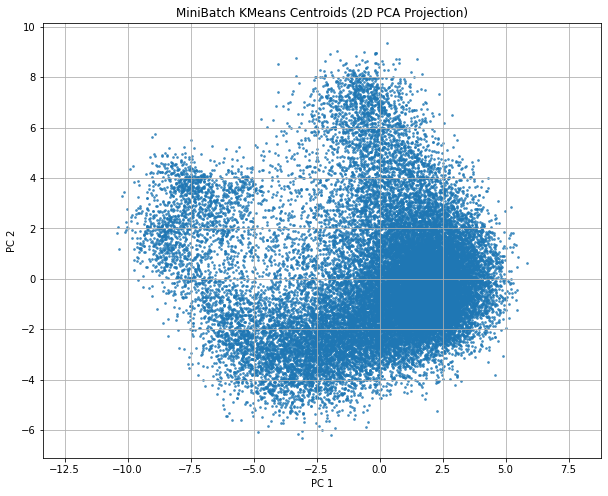

In [19]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

centroids_cpu = centroids.detach().cpu().numpy()

pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids_cpu)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=3, alpha=0.7)
plt.title('MiniBatch KMeans Centroids (2D PCA Projection)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.axis('equal')
plt.show()

In [20]:
np.save('centroids-v2.npy', centroids.cpu().numpy())